In [1]:
from songs import *

# НЕЙРОНКИ

In [2]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MEMORY_TIMES = 64  # сколько предыдущих моментов времени подаётся на вход
STARTER = 8        # сколько первых моментов времени берём для старта импровизации

ADDITIONAL_MEMORY = 8  # размер дополнительной памяти (в тек. версии - отметки о началах такта)

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY  # суммарный объём памяти

In [4]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]

NAMES = []  # названия входов
for i in range(8):  # отметки о долях идут первыми
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [5]:
class Edge:  # класс связи между нейронами
    def __init__(self, inp, outp, w, was_right=[1, 1], precedents=[1, 1]):
        self.input = inp
        self.output = outp
        self.weight = w
        
        # важные статистики: количество верных ответов вида -1 и 1, и число прецендентов.
        self.was_right = was_right[:]
        self.precedents = precedents[:]
        
    def quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() == 1] / self.precedents[self.input.emitted() == 1]
    
    def op_quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() != 1] / self.precedents[self.input.emitted() != 1]

class Neuron:
    def __init__(self, index, name="", was_one=1, used=2, is_base=False):
        self.name = name        # название для отображения в графе
        
        self.index = index      # номер соответствует индексу в массиве нейронов сети. Это защита от циклов.
        self.is_base = is_base  # пометка, что это вход или выход, и трогать его нельзя
        
        self.inputs = []        # список входов
        self.outputs = []       # список выходов
        self.signal = 0         # сумма текущих входов
        
        # важная статистика: как часто нейрон выдаёт 1
        self.was_one = was_one   # сколько раз сигнал равнялся 1
        self.used = used        # сколько раз вообще проводился запуск
        
        # переменная для хранения качества сигнала
        self.signal_quality = 1
        
        # равно true, если этот нейрон внёс вклад в правильный ответ на каком-то выходе в текущем запуске
        self.success = False
        
    # вспомогательные функции
    def emitted(self):
        # значение выхода по сумме входов - пороговая функция по нулю
        if self.signal > 0:
            return 1
        return -1    
    def getSureness(self):
        # сколько входов нужно инвертировать, чтобы получить другой ответ
        if self.signal > 0:
            return (self.signal + 1) // 2
        else:
            return 1 + (-self.signal) // 2
    def getError(self):
        # ошибка в количестве голосов
        if self.signal > 0:
            return self.signal
        else:
            return 1 - self.signal
        
    def initialize(self):
        # инициализация перед запуском
        self.signal = 0
        self.signal_quality = []
        self.success = False
    def emit(self, neurons):
        # функция "срабатывание" нейрона
        
        self.used += 1  # подсчёт статистик
        if self.signal > 0:
            self.was_one += 1
        
        sureness = self.getSureness()
            
        if len(self.signal_quality) == 0:
            self.signal_quality = 1
        else:
            self.signal_quality = sorted(self.signal_quality)[sureness - 1]
        
        for edge in self.outputs:  # перебор выходов
            edge.output.signal += edge.weight * self.emitted()  # добавление в сумму своего вклада
            
            # обновляем качество сигнала: оно равняется минимальному качеству входа, 
            # где качество входа - качество сигнала на входе * качество связи
            edge.output.signal_quality.append(edge.quality() * self.signal_quality)   
                
    def reward(self, true_val, error_proba=1):
        # оценивание связи по известному правильному ответу
        
        if self.emitted() == true_val:  # если выдал нужный сигнал, помечаем нейрон как "не трожь!"
            self.success = True
            
        sureness = self.getSureness()
                   
        for edge in self.inputs:
            input_val = edge.input.emitted()  # входной сигнал
            
            edge.precedents[input_val == 1] += 1# * error_proba
            if input_val * edge.weight == true_val:
                edge.was_right[input_val == 1] += 1# * error_proba

            edge.input.reward(true_val * edge.weight, error_proba / sureness)  # переходим во вход рекурсивно

In [149]:
class Func:
    def __init__(self):
        # нейроны-входы
        self.neurons = [Neuron(i, name=NAMES[i], was_one=0, used=1, is_base=True) for i in range(MEMORY_SIZE)]
        # нейроны-выходы
        for i in range(13):                                                                  
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", was_one=0, used=1, is_base=True)) 
        
        self.IDS = 0  # id нужны, чтобы различать нейроны, и давать имена скрытым нейронам.
        self.Random = np.random.RandomState(seed=179)  # рандом       
        self.verbose = False  # отладка
        
        self.Drones = [[None, None, None, None] for i in range(13)]
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
        
        # посылаем сигналы на нужные входы
        for i, val in enumerate(x):  
            if val == 1:
                self.neurons[i].signal += 1
        
        # запускаем нейроны
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].emitted() == 1 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            if val == 1:
                self.neurons[-13+i].reward(1)
            else:
                self.neurons[-13+i].reward(-1)
            
    def forget_info(self):  # сбрасывание всех статистик - опциональная возможность. "Выучил выборку - пересчитай статистики".
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = [1, 1]
                edge.precedents = [1, 1]
            
            if N.is_base:
                N.was_one = 0
                N.used = 1
            else:
                N.was_one = 1
                N.used = 2
    
    def randomOne(self, conseq):   # выбор случайного нейрона для создания гипотезы
        # гипотеза в данном контексте - это новая связь
        # гипотеза тем акутальнее, чем более специфично выбранное событие для текущей ситуации
        # то есть хочется выбрать гипотезу, которая срабатывает именно в этом запуске
        # для этого хочется взять событие, которое случилось в данном запуске, но его априорная вероятность очень мала
        # то есть выудить из текущего события какую-нибудь ценную информацию
        # поэтому вероятность выбора гипотезы пропорциональна 1 - P(события)
        
        candidates = []  # список нейронов-кандидатов
        proba = []       # список вероятностей, с котороыми мы их выберем
        
        # перебираем нейроны, стоящие в массиве до следствия, чтобы избежать циклов
        # также мы не берём выходы всей сети (последние 13 нейронов)
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            # ВАЖНО! тут по идеи должна стоять защита от случая, 
            # что этот нейрон уже используется как вход для conseq. Однако...
            candidates.append(N) 
            
            # считаем вероятность
            if N.emitted() == 1:  
                proba.append(1 - N.was_one / N.used)
            else:
                proba.append(N.was_one / N.used)
        
        # делаем случайный выбор
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if self.verbose:
            print("new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        # нейрон отваливается, если у него нет входов или выходов
        # эта функция делает проверку очереди neurons_queue на такие нейроны
        # и уничтожает отвалившиеся
        
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                # окончательное удаление из списка
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
                
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print("remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать: возвращаем очередь для проверки
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge):
        # добавление заглушки, т.е. нового нейрона в сеть
        # выбирается связь, по которой прошёл неверный сигнал, и разрывается нейроном
        # веса для двух новых связей выбираются так, чтобы произведение равнялось весу исходной связи
        # При этом варианта в любом случае два. Заведомо известно, что в стабе будет ошибка, 
        # а количество голосов будет -1 или 1 в зависимости от сигнала с единственного входа
        # Поскольку при 0 нейрон выдаёт -1, то проще 1 исправить в 0, чем -1 в 1
        # => выбираем тот вариант, при котором в стаб придёт сигнал 1
        
        # вычисление положения нейрона в сети. Он должен быть между входом и выходом разрываемой связи
        # и не задеть входной и выходной слой!
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        # Вообще-то, тут можно ещё вычислить априорную вероятность 1 для нового нейрона (соотв. вероятности единственного входа)
        # ну пока этого нет
        
        # добавление нейрона
        stub = Neuron(stub_index, name=str(self.IDS))
        self.IDS += 1
        
        for neuron in self.neurons[stub_index:]:  # индекс последующих нейронов смещается на единицу
            neuron.index += 1
        self.neurons.insert(stub_index, stub)
        
        stub.signal = 1  # заполняем параметры текущего запуска для корректной работы
        stub.signal_quality = edge.input.signal_quality * edge.quality()
        
        if self.verbose:
            print("created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # решение уравнения на новые два веса: сигнал со входа; сигнал со входа на исходный вес.
        # при перемножении дадут исходный вес; в стаб придёт 1
        
        # изначальные оценки связей берём из разорванной связи?
        inp_signal = edge.input.emitted()
        self.connect(edge.input, stub, inp_signal)#, edge.was_right, edge.precedents)
        self.connect(stub, edge.output, inp_signal * edge.weight)#, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
    
    def respawn(self, output, wish):
        return self.Random.choice(self.neurons[MEMORY_SIZE:])
        N = self.neurons[-13 + output]
        current_wish = wish
        variants = []
        while not N.success and N.index >= MEMORY_SIZE:            
            variants.append(N)
                       
            paths = []
            paths_proba = []
            for edge in N.inputs:
                    if edge.input.emitted() * edge.weight != current_wish:
                        paths.append(edge)
                        paths_proba.append(1 - edge.quality())      # или edge.input.signal_quality?!?!?
            
            if len(paths) > 0:
                paths_proba = np.array(paths_proba)
                paths_proba /= paths_proba.sum()
                c = self.Random.choice(np.arange(len(paths)), p=paths_proba)
                chosen_edge = paths[c]
                
                N = chosen_edge.input
                current_wish *= chosen_edge.weight              
            else:
                break
        return self.Random.choice(variants)
    
    def turn(self, output, wish):
        # АЛГОРИТМ ПОПРАВКИ!        
        i = 0
        while True:
            if self.Drones[output][i] is None or not self.Drones[output][i] in self.neurons:
                self.Drones[output][i] = self.respawn(output, wish)
            else:
                if ((i == 0 or i == 2)  
                           and not self.Drones[output][i].success 
                           and not self.Drones[output][i].index < MEMORY_SIZE
                           and self.Drones[output][i].getError() == 1):
                    one = self.randomOne(self.Drones[output][i])
                    self.connect(one, self.Drones[output][i], -self.Drones[output][i].emitted() * one.emitted())
                    return
                
                if self.Drones[output][i].success:
                    variants = []
                    for edge in self.Drones[output][i].outputs:
                        if edge.output.emitted() != edge.weight * edge.input.emitted():
                            variants.append(edge)
                    
                    if len(variants) == 0:
                        self.Drones[output][i] = None
                    else:
                        edge = self.Random.choice(variants)
                        
                        self.Drones[output][i] = edge.output
                        if i == 1 and self.Random.uniform(0, 1) < edge.quality() * edge.op_quality():
                            # Ошибка со связью. Строим стаб.
                            stub = self.add_stub(edge)

                            one = self.randomOne(stub)
                            self.connect(one, stub, -one.emitted())
                            return
                else:
                    variants = []
                    for edge in self.Drones[output][i].inputs:
                        if edge.input.emitted() == edge.weight * edge.output.emitted():
                            variants.append(edge)
                    
                    if len(variants) == 0:
                        self.Drones[output][i] = None
                    else:
                        edge = self.Random.choice(variants)
                        
                        self.Drones[output][i] = edge.input
                        if i == 3 and self.Random.uniform(0, 1) < 1 - edge.quality():
                            # Ошибка со связью. Строим стаб.
                            self.check_for_blow(self.disconnect(edge))
                            return                 
            
            i = (i + 1) % 4
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.was_one / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, 
                         label = "{0:.2f}".format(edge.was_right[0] / edge.precedents[0]) + 
                           "/" + "{0:.2f}".format(edge.was_right[1] / edge.precedents[1]))
        #dot.render(view=True)
        return dot

In [150]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        # считаем ошибки
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(note, 1)
                        else:
                            self.play_note.turn(note, -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [151]:
player = Player()

In [152]:
kuznechik = Song('../basic midi/track (1).mid')

In [155]:
player.learn_to_play(kuznechik, verbose=True, limit=128)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
remove edge between layers:  G#-2 ( 822 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
remove edge between layers:  [tb2] ( 2 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
remove edge between layers:  G#-6 ( 770 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  A-8 ( 745 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  G#-43 ( 289 )  /  Eoutp ( 844 )
[0 0 0 0 1 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  E-37 ( 363 )  /  Eoutp ( 844 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  G#-39 ( 341 )  /  Eoutp ( 844 )
[0 0 0 0 1 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  E-5 ( 779 )  /  Eoutp ( 844 )
[0 0 0 0 1 0 0 0 1 0 0 0 0]
remove edge between laye

81

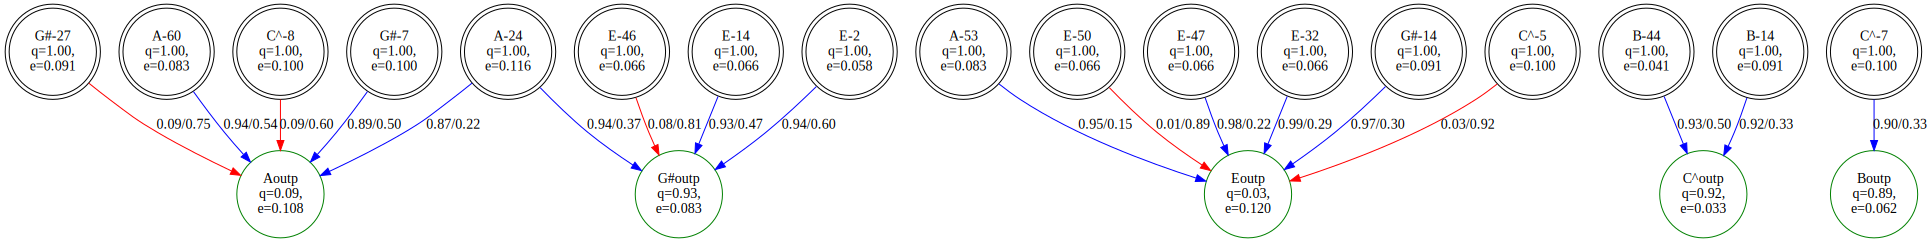

In [156]:
player.play_note.draw()

In [157]:
#player.play_note.draw().render("Бинарный слон запомнил (с FI) кузнечика (54 скрытых нейрона)")

In [158]:
len(player.play_note.neurons[-5].inputs)

4

# Random Path Suicide Elephant



## Моды:
- убрать error_proba при оценке p0-p1

In [159]:
player = Player()

In [160]:
def stubs_input(F):
    return np.array([len(N.inputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()
def stubs_output(F):
    return np.array([len(N.outputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()

In [161]:
limit = 8
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while limit <= 128:#len(kuznechik.notes):
    #player.play_note.forget_info()
    
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons))
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
        stubs_outputs.append(stubs_output(player.play_note))
        stubs_inputs.append(stubs_input(player.play_note))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  853
0 
limit:  9  neurons_at_start:  853
1 0 
limit:  10  neurons_at_start:  853
0 
limit:  11  neurons_at_start:  853
1 1 0 
limit:  12  neurons_at_start:  853
1 2 2 0 
limit:  13  neurons_at_start:  853
1 1 0 
limit:  14  neurons_at_start:  853
0 
limit:  15  neurons_at_start:  853
0 
limit:  16  neurons_at_start:  853
0 
limit:  17  neurons_at_start:  853
0 
limit:  18  neurons_at_start:  853
0 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  



limit:  19  neurons_at_start:  853
1 2 2 1 0 
limit:  20  neurons_at_start:  853
0 
limit:  21  neurons_at_start:  853
1 0 
limit:  22  neurons_at_start:  853
0 
limit:  23  neurons_at_start:  853
1 6 1 1 2 3 2 1 1 3 2 4 4 2 2 3 4 2 1 2 0 
limit:  24  neurons_at_start:  853
0 
limit:  25  neurons_at_start:  853
2 4 7 13 13 7 4 5 3 4 6 4 3 3 3 2 4 1 2 1 2 2 2 2 3 1 2 3 4 4 4 6 6 3 5 4 6 5 3 3 2 2 2 2 2 2 2 2 2 2 3 5 5 5 4 5 5 4 3 3 3 4 4 5 4 4 3 3 3 3 3 1 1 1 1 3 3 3 2 1 3 2 1 1 1 1 3 1 1 1 2 2 2 0 
limit:  26  neurons_at_start:  927
0 
limit:  27  neurons_at_start:  927
3 4 3 3 2 3 3 3 3 3 4 4 3 3 5 5 5 3 4 4 4 3 4 4 4 4 4 4 4 7 4 4 3 2 3 3 1 1 1 1 1 3 5 4 5 8 6 6 5 7 3 3 4 4 6 8 8 6 2 2 5 3 3 3 1 1 1 1 1 1 2 2 3 3 2 1 2 2 3 3 2 2 3 3 3 2 2 2 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 2 2 2 3 4 4 4 5 5 5 6 4 4 4 4 3 5 5 3 2 2 2 2 2 8 5 3 3 2 4 3 4 4 4 5 5 3 3 3 6 3 5 5 9 9 9 16 6 6 6 4 

KeyboardInterrupt: 

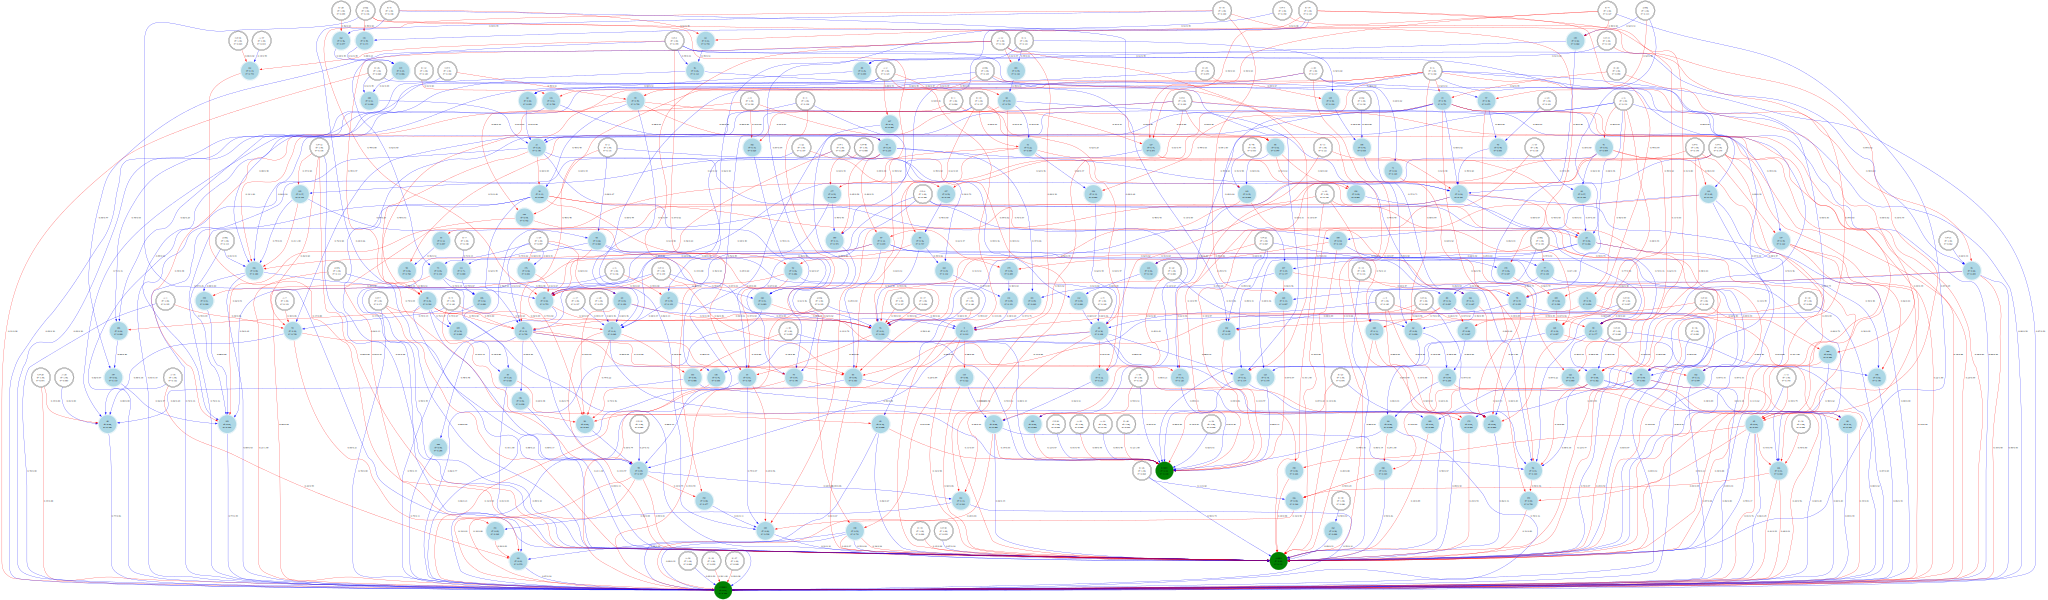

In [145]:
player.play_note.draw()

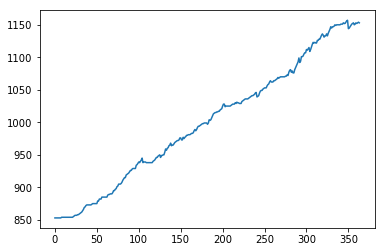

In [85]:
plt.plot(neurons)  # график количества нейронов в эпоху

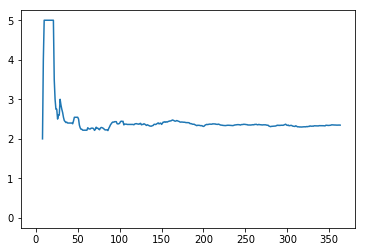

In [86]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

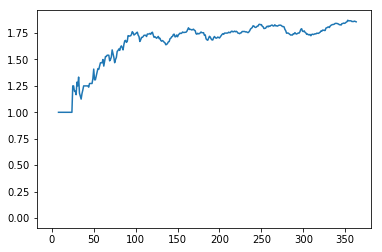

In [87]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

# Базовый вариант

In [238]:
player = Player()

In [239]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]
while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    stubs_outputs.append(stubs_output(player.play_note))
    stubs_inputs.append(stubs_input(player.play_note))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

98 91 101 114 103 88 84 71 84 82 78 85 77 56 57 78 71 99 63 88 61 70 80 69 75 56 60 58 80 94 80 78 52 75 61 65 76 78 80 73 53 60 69 71 78 85 97 92 87 101 74 94 81 91 107 109 76 84 64 84 71 76 77 93 81 85 62 82 67 87 67 68 59 87 80 91 122 96 91 104 98 83 86 77 89 85 78 68 69 86 85 83 77 88 84 76 67 73 67 65 63 81 68 71 92 71 51 80 67 80 69 70 63 56 58 44 65 82 75 62 77 77 93 91 73 91 89 96 82 88 91 80 83 70 74 71 78 70 89 98 102 100 82 68 75 70 88 88 79 88 93 90 113 114 92 83 81 94 106 85 76 80 91 74 98 92 103 78 78 99 69 85 81 67 82 81 61 60 84 62 91 93 76 87 76 59 83 77 72 86 87 65 51 73 79 65 63 69 93 69 71 75 74 72 87 81 70 74 76 74 78 77 50 69 82 82 70 77 70 71 70 84 73 64 70 66 70 81 85 74 60 64 64 54 65 52 58 71 61 84 67 74 63 64 75 78 65 50 75 59 55 73 95 101 59 79 65 76 65 78 65 70 72 87 67 69 70 84 68 76 66 69 86 71 75 58 60 79 74 73 71 66 57 81 70 69 67 63 96 73 81 82 86 85 60 82 77 73 89 106 83 98 96 82 94 101 87 88 85 84 78 94 110 72 68 75 77 69 82 95 87 78 97 86 96 85 89 9

43 47 44 45 46 51 55 39 38 50 43 47 49 53 53 67 49 78 76 60 51 81 65 49 70 76 67 68 87 70 69 67 80 75 63 90 97 82 81 66 88 70 75 76 74 64 92 65 59 58 75 73 74 59 70 76 57 84 73 62 67 71 72 60 62 57 76 70 70 63 62 57 56 68 74 68 67 68 69 93 95 71 90 67 65 74 77 64 63 69 77 69 83 79 79 68 75 90 69 82 103 85 63 75 60 60 82 80 66 63 76 73 74 65 75 66 54 82 58 61 67 68 62 50 65 60 52 55 62 45 49 64 61 57 49 62 48 64 63 50 72 73 65 80 73 66 82 56 70 66 79 65 82 78 69 78 60 65 69 66 68 76 63 73 61 72 70 85 68 79 73 71 75 66 57 55 57 68 65 56 67 64 59 39 57 55 60 85 60 56 66 63 73 92 68 67 57 69 56 59 76 96 72 75 60 58 66 59 64 64 70 47 64 67 55 52 66 73 63 72 63 57 44 55 63 62 62 56 59 63 67 51 53 71 64 51 70 51 62 67 55 47 56 38 67 60 62 58 44 57 54 80 48 69 59 65 60 47 63 58 73 46 63 46 64 44 58 59 57 51 67 53 47 53 47 48 46 54 64 64 69 51 64 62 78 69 65 67 74 76 54 73 61 61 43 71 60 62 61 64 64 58 59 53 65 56 59 53 56 52 36 62 41 46 38 53 59 61 43 53 42 53 57 61 55 48 40 63 70 46 50 45 56 

56 78 90 75 60 82 64 59 68 78 73 65 81 71 78 64 62 58 45 71 61 57 46 48 71 56 74 44 61 74 67 91 69 55 84 97 85 78 76 60 88 71 56 87 59 42 52 56 63 64 58 62 65 79 71 65 62 54 56 71 100 55 55 51 52 54 57 67 64 74 74 71 73 65 67 62 58 71 55 77 64 71 64 89 61 78 81 67 61 65 94 75 81 59 81 81 77 64 59 55 65 83 84 57 60 62 76 65 65 80 78 59 61 74 68 67 50 71 67 91 87 113 80 67 65 79 95 84 72 70 84 74 70 90 63 94 94 69 93 68 61 75 78 83 77 63 72 75 87 81 89 92 74 66 66 70 91 67 51 67 58 47 68 63 71 64 63 76 80 67 72 68 81 88 79 80 88 105 70 63 58 65 71 100 75 60 88 68 68 87 104 95 92 79 65 71 79 80 81 78 87 71 55 80 92 66 60 63 71 61 77 79 79 55 62 84 79 74 77 79 72 77 81 77 67 84 90 87 75 62 67 85 80 78 62 77 98 73 63 70 69 71 80 74 84 89 100 84 67 66 86 73 83 72 84 78 58 56 63 44 82 63 70 51 60 62 58 65 72 69 77 64 71 62 60 60 66 80 78 72 84 109 89 90 74 80 87 82 85 75 85 90 95 91 77 82 80 58 55 72 59 64 52 48 42 39 72 51 60 60 79 52 69 70 77 83 73 64 63 67 61 77 60 60 64 52 64 65 72 63 73 

74 99 75 70 56 76 81 79 77 51 67 61 81 77 85 80 64 49 63 69 55 75 56 56 54 50 58 53 64 61 86 63 69 61 69 83 70 69 65 49 49 45 63 58 57 71 72 61 67 71 58 70 66 52 61 82 58 51 78 60 69 80 82 88 78 80 64 72 74 78 81 62 86 70 79 105 93 100 76 69 63 53 88 84 74 69 71 81 47 54 74 60 45 69 64 65 70 60 77 63 60 68 70 71 95 69 76 83 96 91 76 62 66 75 70 72 67 79 74 64 54 59 61 62 58 63 59 60 89 72 78 56 53 66 83 70 87 62 59 53 74 73 79 78 93 82 67 79 78 59 64 68 82 64 76 69 59 81 69 72 88 63 72 77 80 102 56 54 72 75 95 79 71 84 74 80 78 73 75 60 62 79 73 76 57 59 77 82 64 51 45 59 62 59 65 71 66 81 64 76 75 73 63 63 82 91 92 80 84 85 80 55 58 64 73 69 80 82 74 62 71 76 60 68 63 55 49 45 56 67 68 64 69 52 60 67 49 56 54 61 80 65 73 69 65 81 67 56 63 63 63 78 78 83 72 52 51 74 51 66 63 53 52 46 48 51 41 40 42 49 63 30 56 62 55 57 66 55 61 60 48 46 63 44 69 56 44 50 45 49 56 56 60 49 48 43 38 44 47 42 54 47 54 37 37 36 38 37 52 47 61 62 61 53 55 57 53 63 39 48 43 41 38 38 52 62 44 51 58 43 38 38 4

74 72 76 74 71 50 54 61 54 67 62 68 66 73 55 68 79 55 76 75 71 71 53 60 78 72 68 66 68 73 79 68 83 75 45 46 56 60 53 48 46 51 44 32 42 53 57 40 54 57 55 56 49 55 46 60 59 64 56 49 57 58 55 46 52 37 51 46 62 51 58 52 46 50 55 50 69 66 51 68 57 64 57 54 50 50 61 53 45 50 36 39 41 44 46 36 33 47 57 49 46 44 49 48 45 51 56 35 52 40 55 54 45 43 45 64 42 44 32 46 45 42 47 34 32 40 41 43 35 37 44 48 38 66 53 50 60 54 64 47 58 62 62 55 50 65 51 41 54 47 45 55 69 51 51 63 61 54 43 40 37 59 46 47 51 50 53 51 46 65 56 42 49 40 42 33 35 46 52 46 47 44 45 73 54 66 62 60 62 59 74 59 50 48 69 52 59 60 60 53 62 54 70 61 50 58 63 61 52 71 52 64 57 71 58 53 54 70 64 70 67 49 69 77 73 67 62 75 59 72 67 73 80 92 60 69 67 80 65 87 83 65 77 80 61 65 73 57 73 60 69 61 70 66 86 76 70 71 84 83 65 71 77 97 79 97 79 90 71 67 56 56 70 86 74 68 61 73 62 54 58 54 52 71 50 56 63 53 60 40 43 63 59 66 66 64 93 58 49 85 84 63 67 65 68 71 67 69 45 53 56 62 63 80 90 56 72 81 72 60 80 55 56 56 62 67 65 80 78 82 68 68 83 9

55 47 57 70 77 73 90 66 83 80 77 69 69 77 66 86 95 87 78 79 93 76 89 83 70 75 72 77 91 74 64 63 81 60 58 84 57 89 76 74 68 82 67 65 60 57 67 68 60 86 77 71 71 69 69 77 95 85 78 83 75 91 87 76 71 64 68 68 65 78 73 52 58 62 69 67 60 68 61 74 55 63 62 46 55 51 51 57 60 73 52 53 58 75 59 39 41 47 47 62 72 98 63 60 70 63 61 69 69 53 48 57 34 50 45 47 41 40 49 58 53 38 55 48 46 49 54 58 45 44 34 56 59 53 67 83 43 41 55 60 60 58 49 52 59 72 61 76 78 63 74 79 76 74 62 62 47 43 45 40 51 47 55 59 56 65 68 65 62 66 64 55 48 52 51 62 59 49 60 65 57 55 54 36 47 53 42 49 63 43 47 50 58 55 71 64 55 55 57 53 65 59 62 66 64 61 64 44 50 63 64 68 54 50 62 58 79 60 69 52 52 50 66 54 44 55 48 54 67 77 60 90 69 67 63 52 89 69 79 56 86 75 72 60 53 54 56 55 54 62 60 51 61 56 56 50 43 43 58 64 52 43 39 43 47 51 44 58 45 48 37 44 48 61 58 61 50 50 54 58 66 60 53 77 56 56 63 59 67 55 62 67 55 59 49 44 61 53 48 61 56 46 52 40 48 46 57 58 60 62 77 62 53 40 50 51 59 58 62 68 51 44 47 54 40 45 44 43 38 42 47 61 51 5

71 64 74 64 56 65 75 62 83 78 71 80 87 80 60 63 58 78 83 79 67 75 65 75 69 82 72 101 84 77 77 84 83 79 76 71 64 78 65 72 68 82 77 72 78 60 78 70 63 54 55 75 59 58 57 63 62 71 67 54 63 64 60 69 88 60 70 71 82 81 66 74 74 87 68 84 71 68 76 90 74 57 61 66 71 64 53 58 82 68 74 68 71 73 55 50 62 66 71 62 69 74 83 60 75 90 72 65 74 61 75 77 71 74 71 69 78 73 93 91 80 75 81 86 75 86 85 63 73 68 76 85 77 96 83 73 66 76 64 58 61 49 68 73 67 82 69 75 68 62 72 87 70 69 61 76 60 62 79 67 73 76 81 78 88 85 84 72 88 82 61 59 78 68 79 67 60 81 66 60 61 70 72 62 76 70 86 92 82 82 108 96 96 82 69 67 76 71 60 60 66 77 61 66 74 92 56 79 83 63 53 52 52 81 58 61 71 58 59 55 55 68 61 78 59 68 69 53 51 63 69 73 72 52 59 56 57 66 65 46 47 61 49 46 63 72 55 71 57 55 66 63 63 67 65 64 73 67 64 55 56 68 58 82 64 54 44 51 53 54 50 59 59 56 76 67 44 43 48 63 61 61 52 67 61 46 58 62 59 58 55 69 56 51 59 46 50 45 56 58 61 61 66 69 59 47 69 60 52 52 72 50 52 50 54 71 48 62 44 57 54 53 66 57 58 60 65 62 63 66 59 63 80

42 44 56 66 70 57 56 55 42 55 58 55 45 64 61 58 62 45 57 65 55 51 50 51 45 47 45 44 42 41 50 38 50 57 62 37 62 55 38 53 46 40 46 46 56 47 43 52 44 41 42 47 50 45 53 59 58 64 60 55 61 71 71 82 62 61 56 33 62 50 52 66 60 53 68 54 41 40 34 38 62 54 72 53 56 49 53 58 52 59 58 67 45 48 60 81 85 77 47 51 52 52 67 74 54 67 78 69 57 51 59 59 67 66 53 47 64 55 55 53 64 64 62 53 56 77 71 65 42 65 62 50 48 44 44 79 62 46 46 54 55 58 51 60 57 73 86 76 78 52 81 78 59 70 87 94 100 77 74 77 71 69 74 85 86 60 75 60 60 54 60 63 70 89 57 70 74 64 65 60 56 70 58 56 44 68 56 57 54 42 50 57 74 54 59 63 58 48 61 45 55 66 47 69 57 50 61 59 55 55 53 54 51 58 51 49 52 49 63 54 54 44 50 54 52 50 59 55 44 47 48 54 48 47 38 38 31 42 46 42 46 49 65 59 47 47 57 40 47 69 50 46 45 56 47 41 49 43 46 50 40 44 45 55 44 53 40 40 45 41 46 44 62 56 62 48 52 60 53 67 58 47 41 49 43 58 50 52 56 43 53 56 42 51 36 56 43 40 40 34 37 36 36 47 52 60 50 40 52 57 56 41 46 46 43 45 60 48 51 59 52 40 45 57 46 66 69 52 52 56 61 48 45 

47 47 46 51 48 57 60 39 61 55 50 57 67 59 60 59 48 51 55 54 47 55 39 37 55 49 47 50 40 56 52 45 64 56 75 78 45 51 62 70 70 58 55 62 52 52 44 54 50 62 64 49 52 53 52 34 35 49 53 44 45 46 56 29 48 43 54 42 46 40 47 39 48 44 50 69 58 48 60 57 57 44 46 60 55 63 45 41 48 49 53 41 60 49 52 57 67 44 42 47 51 49 42 48 39 45 53 55 43 34 79 34 40 44 50 37 51 53 54 39 33 36 32 35 39 40 21 46 50 30 37 28 46 44 58 57 41 61 48 53 50 38 63 63 49 49 52 50 46 46 46 52 52 57 44 67 47 52 64 61 55 69 61 68 58 45 46 64 62 70 72 55 53 49 42 54 84 69 69 59 44 58 79 63 55 51 63 72 71 77 65 50 72 54 90 76 67 54 52 52 67 77 67 76 70 60 70 82 63 44 66 57 61 62 71 48 66 66 79 75 65 50 48 47 55 51 63 72 55 52 52 53 49 45 45 32 47 57 69 67 68 73 50 51 41 50 46 62 56 51 64 61 59 56 54 56 64 65 60 46 52 55 52 53 60 56 49 42 55 62 68 60 69 59 53 60 62 69 60 38 57 40 44 57 60 68 64 67 61 72 77 66 56 62 53 71 61 57 64 66 68 67 80 72 75 63 70 62 55 79 67 48 59 59 57 52 50 54 54 44 54 51 66 47 57 46 51 54 59 51 52 58 54 5

80 69 61 68 58 52 70 58 42 51 62 56 63 79 81 76 78 74 57 54 63 58 57 58 49 52 60 64 56 60 61 54 56 48 59 72 73 63 56 63 82 55 55 58 55 42 63 53 63 60 74 62 49 63 51 69 60 55 63 56 44 69 50 52 56 58 71 66 42 57 61 61 68 61 68 74 81 65 62 54 66 58 70 51 53 62 55 69 74 74 74 84 68 59 66 75 58 102 61 57 65 87 76 79 76 68 66 71 66 87 61 69 71 79 74 71 84 66 65 63 63 82 64 64 47 64 77 78 71 80 59 49 63 68 81 94 61 58 54 67 70 55 71 61 59 51 56 57 63 58 59 58 71 77 69 86 70 60 70 62 67 52 72 59 69 68 68 79 76 65 63 73 52 71 50 58 63 80 95 74 60 67 86 60 61 85 52 76 64 62 69 64 81 65 79 73 62 71 73 76 80 81 67 96 71 80 73 67 87 91 71 77 86 82 85 73 74 70 91 69 81 82 72 70 67 78 85 83 89 62 65 65 78 66 58 60 63 62 73 76 78 68 62 77 83 74 61 76 53 62 73 86 69 60 52 54 50 50 73 64 51 47 48 50 61 52 56 61 70 55 48 54 56 47 51 61 47 53 38 47 54 61 59 56 61 77 74 75 73 70 81 76 69 71 73 72 73 54 68 58 87 69 76 67 98 59 68 65 69 51 86 82 79 75 79 68 87 77 73 67 73 66 78 80 61 71 53 75 84 68 64 58 59 

68 71 96 65 65 75 77 77 87 58 50 55 64 72 57 63 60 55 70 59 65 50 49 54 41 59 58 62 68 85 69 59 69 65 59 62 55 62 81 79 58 82 73 70 66 53 64 69 71 69 65 74 70 48 58 75 68 65 70 65 66 74 69 61 67 56 47 44 39 51 45 38 41 64 71 77 85 54 58 40 57 40 58 46 51 65 42 51 57 54 52 55 48 60 59 64 58 46 65 55 48 58 42 60 68 57 55 60 58 60 65 38 55 57 80 73 71 53 50 70 59 57 75 46 45 53 56 61 79 57 64 52 62 59 56 56 66 56 62 78 71 78 45 58 60 64 59 61 65 54 68 64 57 77 66 55 71 63 49 46 48 54 44 45 42 52 46 60 46 54 64 54 66 61 73 68 64 69 55 56 60 67 77 91 80 78 83 90 79 88 86 73 66 76 77 65 64 61 68 67 66 63 69 64 58 66 74 71 74 70 56 66 59 61 54 66 60 53 59 75 70 75 76 78 74 67 92 65 58 59 69 61 61 63 69 59 62 52 37 59 69 66 48 43 42 45 63 54 52 62 53 66 80 85 65 67 71 62 81 61 77 78 78 70 90 75 72 70 65 50 45 44 49 55 61 59 70 62 53 56 55 55 53 45 40 58 52 45 47 54 66 59 51 66 76 63 74 52 90 82 58 58 77 65 54 84 72 61 53 79 69 78 58 72 56 65 74 51 73 66 66 46 59 62 48 38 54 64 69 60 69 57 75 6

54 74 78 50 47 70 62 59 56 52 69 54 55 42 60 40 37 58 69 68 49 53 59 67 47 48 66 53 45 41 42 47 37 47 55 73 55 69 67 85 81 58 69 67 66 79 69 69 65 72 77 80 65 65 75 63 95 68 62 78 97 78 84 81 88 74 87 61 62 53 57 37 44 57 50 49 43 56 56 53 53 56 55 66 68 52 79 67 66 70 82 59 66 57 67 65 64 69 76 73 76 76 89 88 90 58 72 47 47 58 45 51 62 63 69 86 70 72 70 66 52 50 54 60 56 88 73 57 63 72 74 72 72 65 72 74 82 86 116 78 101 66 67 72 97 70 63 58 64 80 71 80 85 75 69 82 71 66 70 90 90 77 61 65 66 76 82 72 62 68 85 92 74 75 62 67 75 74 74 84 64 77 66 72 65 79 58 62 72 79 87 83 91 75 75 71 90 75 83 90 120 87 69 74 78 89 86 82 57 67 68 74 71 82 67 64 92 94 71 66 61 74 61 67 53 70 72 94 72 91 60 74 74 73 74 78 81 69 59 73 70 103 89 78 78 82 89 79 57 58 78 74 81 88 63 82 74 96 78 86 100 92 82 68 77 76 78 87 89 71 75 60 90 87 62 48 79 69 99 79 86 63 68 74 74 80 95 77 84 90 77 73 115 94 88 78 70 60 61 72 77 82 75 75 76 58 63 80 86 91 68 74 70 75 71 76 63 85 57 58 76 59 70 84 76 63 68 78 56 64 67 7

47 50 42 45 36 40 25 37 36 32 46 43 35 35 37 36 39 38 44 28 29 28 32 34 43 30 39 36 31 37 28 22 23 29 29 35 39 44 29 31 35 47 35 27 36 28 41 49 36 36 44 30 27 32 34 28 34 35 34 28 41 40 32 31 40 37 28 30 30 48 45 57 40 45 47 50 50 45 37 35 38 37 36 30 47 58 49 47 55 40 42 51 56 41 53 56 39 52 55 39 50 48 50 38 49 55 44 58 50 57 45 39 57 52 54 58 58 58 54 34 52 52 63 46 49 39 37 33 47 41 54 46 42 39 44 36 39 41 40 43 48 44 47 42 39 52 60 58 53 49 50 43 42 49 52 38 47 58 54 55 63 49 67 69 79 63 65 65 59 46 39 47 45 50 48 52 55 47 66 66 55 69 71 54 76 71 71 66 72 75 64 72 72 77 75 71 81 66 57 59 91 76 68 74 69 75 55 55 81 63 59 75 75 69 62 65 75 61 56 60 60 78 66 66 61 48 53 63 82 46 68 65 79 48 70 70 57 66 69 85 74 63 47 61 55 73 71 81 67 56 66 57 36 53 48 39 46 61 42 72 50 92 73 68 65 54 69 66 83 55 74 68 61 63 59 68 97 83 77 62 81 72 75 67 76 71 67 84 73 67 66 67 47 50 61 71 63 58 77 49 58 45 60 45 61 58 51 54 45 46 38 42 43 35 42 49 41 63 53 54 59 58 49 61 69 56 68 55 60 72 54 57 60 4

49 62 67 65 56 62 81 76 57 63 64 56 76 54 62 62 47 66 63 59 58 54 50 56 63 71 62 67 84 71 77 77 73 59 72 64 68 78 78 64 57 53 55 78 48 51 50 48 48 70 72 59 62 78 71 58 61 63 60 65 63 86 68 72 64 63 62 70 61 58 80 51 72 77 64 72 75 77 52 44 62 67 55 59 68 57 60 71 56 56 49 53 52 55 72 58 48 47 46 50 75 61 57 56 72 75 59 48 58 57 58 62 45 62 53 39 50 51 55 61 48 48 56 55 53 67 65 63 71 64 57 69 54 52 69 82 78 57 53 60 78 59 65 63 66 65 85 81 86 73 55 73 76 74 71 58 64 77 64 65 71 90 60 66 85 70 63 76 74 66 84 72 50 85 48 41 63 59 77 61 67 57 69 64 69 66 71 72 63 51 52 39 64 73 52 80 52 77 80 75 68 96 60 60 67 56 62 56 65 67 61 56 35 40 59 71 78 64 68 59 64 62 62 69 103 70 54 68 52 49 68 55 68 71 60 81 72 64 59 50 84 43 57 76 76 61 57 60 54 49 72 60 58 77 73 70 76 72 63 63 70 67 59 66 81 62 70 57 68 71 67 57 44 52 48 53 45 50 45 49 43 46 55 61 52 45 73 61 57 69 59 65 60 75 76 70 68 59 63 65 68 57 76 67 67 62 79 91 94 65 66 76 79 86 105 74 65 72 84 77 71 78 69 83 74 63 76 70 67 51 58 66 47

51 65 85 56 61 68 69 84 70 72 54 62 63 56 63 66 69 64 56 52 67 50 49 74 81 61 56 66 73 62 54 59 70 71 57 47 52 76 56 77 95 61 62 86 61 57 65 85 64 49 63 70 70 58 64 64 62 46 59 50 68 68 60 64 58 47 72 75 48 45 60 53 79 61 58 59 61 84 61 59 53 51 64 82 51 45 78 70 52 66 60 59 59 60 52 72 45 51 60 61 79 71 70 84 64 59 79 84 73 61 71 66 65 81 74 63 66 66 71 41 45 53 40 54 58 72 67 82 78 57 64 49 87 86 77 86 64 65 65 57 72 54 50 53 60 48 64 64 62 73 70 56 69 66 71 77 76 73 57 59 58 54 68 81 68 67 80 65 60 58 64 68 51 65 56 49 61 65 42 46 66 55 56 73 77 86 89 70 73 96 86 80 69 77 57 67 92 66 65 67 73 71 63 73 84 78 63 69 72 71 65 67 67 62 66 76 66 75 38 54 62 66 84 90 83 69 71 65 81 74 61 70 73 70 67 68 58 76 73 85 74 75 67 59 61 62 58 70 65 63 64 66 66 70 57 51 60 74 53 55 50 52 69 49 64 57 48 56 39 53 67 54 70 67 72 83 72 70 75 66 57 66 58 53 66 58 63 59 71 58 55 73 68 69 55 49 66 61 72 72 65 83 96 76 76 69 85 71 64 90 66 68 88 75 67 54 59 62 57 53 41 53 50 61 74 82 66 77 65 85 76 83 59 5

50 42 30 28 35 44 36 39 32 42 41 55 35 33 32 38 31 30 34 37 36 32 26 31 33 35 27 39 38 43 40 42 45 52 50 51 44 55 39 61 41 44 42 50 58 42 33 37 56 42 43 40 45 41 32 41 50 42 48 37 34 50 40 32 59 46 34 35 45 39 41 38 32 44 30 30 33 33 38 39 34 34 53 36 36 38 33 43 63 43 34 56 52 49 47 38 47 49 30 29 32 31 37 33 31 31 31 39 41 33 38 30 37 44 38 33 39 39 53 52 42 43 35 34 50 53 41 40 42 30 41 43 52 53 66 67 40 53 42 64 54 65 47 50 59 54 75 69 65 43 41 52 37 41 40 58 57 59 43 60 37 53 61 56 60 56 59 58 62 56 62 62 65 49 63 56 57 61 49 59 61 60 52 51 50 59 46 41 73 62 58 42 44 47 52 35 40 54 57 50 64 52 56 68 59 51 60 58 57 48 39 35 39 37 42 43 54 52 52 51 56 48 54 62 49 59 51 62 56 67 61 54 75 53 67 64 63 61 65 63 72 65 65 43 62 63 54 65 73 53 63 77 58 61 59 58 58 58 44 60 47 48 51 57 68 67 55 82 63 42 41 53 66 72 64 51 55 66 67 45 59 66 50 63 66 57 59 71 73 63 48 70 72 73 73 71 72 78 60 70 54 45 59 56 52 59 55 56 66 69 50 61 63 71 63 64 60 54 62 47 43 57 55 61 56 64 55 47 61 59 67 67 73 6

34 56 72 58 69 53 52 65 75 58 60 51 52 55 74 63 64 62 56 54 41 51 54 54 59 66 75 63 67 73 63 52 76 62 49 45 38 43 32 30 39 41 42 47 48 39 46 43 46 32 48 32 39 34 41 47 49 33 32 37 41 47 55 57 61 58 47 48 74 58 43 48 52 45 64 65 52 46 44 52 56 53 50 59 43 64 57 66 53 50 44 49 48 62 55 49 63 59 44 50 51 53 71 62 81 53 59 66 53 64 67 79 64 66 52 62 57 54 40 44 56 45 39 50 48 57 55 49 49 54 39 48 50 42 51 53 48 45 42 40 36 56 55 46 51 41 39 59 50 45 43 64 40 44 38 35 32 39 41 53 39 43 47 46 35 43 51 48 65 54 44 45 52 50 48 44 47 45 41 49 46 57 51 41 32 44 29 33 43 48 49 43 44 44 45 38 31 42 40 47 35 38 52 41 40 35 36 36 36 46 44 36 44 54 50 61 47 39 51 48 31 34 40 37 26 38 39 46 43 41 58 50 57 49 40 46 47 41 50 50 46 46 55 42 60 47 64 72 48 42 41 50 46 43 55 60 45 58 54 53 55 64 49 55 58 49 45 37 38 50 52 50 61 66 58 72 80 66 66 79 73 68 55 59 64 67 73 81 103 81 87 59 68 65 82 58 74 70 50 55 69 58 49 86 68 47 56 41 64 45 60 47 38 49 43 40 49 51 43 59 50 59 49 54 53 51 55 56 58 44 43 45 48 

78 64 71 100 78 71 71 75 81 73 77 63 54 62 66 62 76 79 111 94 86 75 83 90 83 69 71 57 86 58 75 104 97 66 71 79 60 54 69 55 79 60 76 78 99 71 91 77 75 76 64 70 56 57 87 56 44 50 69 61 73 57 62 64 54 52 74 89 73 68 71 68 59 73 53 84 58 77 62 57 67 84 63 67 80 73 54 62 62 79 56 59 60 75 58 63 86 72 61 55 55 59 51 55 66 69 54 57 66 48 40 57 59 52 49 57 55 64 79 59 58 57 66 77 71 75 46 55 75 57 66 57 48 71 59 48 63 64 70 59 58 74 77 72 65 63 70 58 68 63 58 50 49 53 51 53 70 65 62 52 70 66 66 52 48 51 75 68 82 62 68 72 53 75 74 72 60 69 64 79 69 56 47 73 63 73 63 59 69 56 55 56 75 78 63 70 84 73 58 65 79 67 76 59 52 59 82 96 85 90 63 89 72 75 74 63 78 74 72 62 86 61 83 69 62 59 64 54 51 50 62 65 72 72 63 54 70 68 61 55 55 78 66 52 62 85 55 57 57 65 64 59 64 63 63 60 51 52 51 49 54 52 68 62 65 61 60 55 52 56 53 62 62 54 63 70 63 48 66 71 59 58 66 74 73 71 80 85 79 59 51 71 79 76 71 75 65 66 89 65 69 64 58 68 75 76 65 70 62 74 62 66 70 63 61 57 58 82 66 77 97 92 90 57 64 76 92 66 82 86 64 72 6

83 59 49 51 57 56 70 57 42 57 51 56 72 70 66 81 66 81 60 77 61 65 63 72 56 66 40 46 44 59 47 49 35 43 54 68 50 45 54 55 75 59 57 55 57 60 68 61 70 59 73 69 70 63 68 72 72 81 63 76 84 89 105 78 60 74 78 81 73 100 96 91 76 66 85 62 72 69 87 55 81 67 67 82 59 75 64 70 56 83 81 90 86 50 84 92 86 90 100 67 67 69 84 68 60 77 90 61 87 60 66 61 64 63 75 94 55 72 87 75 70 82 79 74 70 64 73 71 58 79 83 93 108 82 78 73 78 87 83 68 54 86 102 75 76 70 73 75 70 57 69 71 68 57 69 59 62 64 61 88 69 61 81 65 56 57 62 61 71 73 75 68 61 78 89 67 60 60 59 46 55 56 50 50 45 46 59 68 61 79 66 55 51 51 54 75 60 77 52 48 57 53 51 70 56 42 53 60 65 58 43 58 51 54 55 58 44 45 55 43 59 42 51 45 63 57 63 57 49 62 41 46 53 52 43 49 47 48 65 61 55 59 50 57 50 62 50 64 49 66 69 54 43 43 45 52 66 59 46 38 53 62 52 50 57 57 58 74 68 60 49 63 66 52 50 47 53 43 35 41 51 60 34 57 43 57 55 45 57 42 49 45 45 44 42 55 52 55 45 50 45 67 63 58 52 46 44 36 50 45 47 63 51 53 65 51 65 46 36 45 50 48 56 53 54 47 56 55 56 66 62 53

65 65 79 70 65 71 67 61 70 61 63 52 60 66 75 76 66 52 67 56 51 50 33 31 35 48 49 53 37 48 60 57 55 44 58 56 66 62 53 56 51 52 56 62 69 63 53 53 43 57 38 51 58 64 58 56 54 57 64 42 41 64 64 56 75 52 43 63 64 77 58 62 66 56 64 61 51 54 53 42 50 53 63 49 68 79 42 60 60 44 42 55 48 48 50 62 56 58 57 60 56 70 59 51 79 67 67 66 47 69 65 65 60 50 48 68 71 50 55 56 85 71 50 56 64 52 47 49 63 70 58 64 54 70 62 72 61 57 50 57 47 47 56 61 73 58 67 47 57 87 63 66 55 69 58 50 55 59 65 68 75 70 54 66 56 47 50 59 57 64 61 71 55 63 75 72 58 76 47 60 65 68 61 57 50 57 76 66 61 78 56 60 63 60 58 50 54 55 68 56 78 74 67 63 52 49 64 66 60 62 73 54 69 57 58 49 54 61 63 59 51 53 44 44 49 54 56 56 38 49 41 43 39 41 38 52 56 54 51 62 47 56 56 82 60 67 64 54 59 42 47 47 52 50 44 47 42 56 47 42 52 67 61 51 55 52 51 61 55 60 53 50 52 48 43 43 47 59 37 35 41 53 45 48 51 68 57 59 49 60 55 58 52 50 59 50 52 68 70 65 61 58 60 57 67 70 70 58 66 51 78 71 74 63 83 82 67 70 73 71 76 76 46 63 76 59 70 54 68 52 61 58 82 4

54 51 59 53 54 63 62 44 66 67 68 86 70 76 77 81 58 58 74 56 50 53 48 54 68 46 46 51 63 70 66 56 65 60 58 66 84 74 73 73 50 71 85 64 89 77 78 67 86 74 82 82 61 64 63 73 65 76 53 68 68 40 63 44 47 46 76 50 41 62 59 48 54 67 57 39 48 64 58 33 51 48 47 49 50 58 67 61 62 49 50 64 64 63 70 56 66 57 51 62 47 43 46 61 58 56 47 60 55 54 49 69 70 57 84 75 68 70 67 53 69 64 70 56 56 78 56 69 67 77 52 49 57 49 54 45 57 58 62 69 64 63 68 61 57 71 62 67 76 92 68 72 57 69 60 52 44 79 76 75 66 53 53 77 73 60 72 70 91 79 65 69 58 67 75 80 77 84 70 65 67 79 71 59 75 97 73 81 81 70 64 65 67 64 74 91 78 66 72 55 64 69 61 52 76 66 56 67 72 67 69 84 76 81 69 67 54 63 65 66 71 62 65 71 70 66 68 81 53 64 59 66 69 56 70 62 40 55 72 59 67 66 59 56 53 52 62 58 61 51 54 70 75 71 58 72 70 66 73 81 78 88 81 69 75 59 74 61 60 79 66 82 64 88 69 86 85 99 88 67 60 72 65 69 66 58 77 85 75 73 80 69 76 75 81 92 79 72 85 73 77 66 76 76 86 102 104 79 77 84 79 85 80 73 76 93 89 81 85 55 71 85 67 58 83 76 80 71 61 66 57 77 80

47 38 36 48 40 43 38 44 40 40 51 40 61 48 36 37 32 34 28 28 35 37 38 28 44 43 45 43 35 40 42 29 26 38 41 49 39 55 40 35 41 37 33 39 45 55 41 44 46 46 39 50 36 37 30 45 56 47 47 42 42 53 60 46 63 47 53 34 37 46 40 39 25 45 37 39 38 50 33 32 41 46 34 26 29 36 28 27 25 28 34 33 39 37 44 31 39 43 38 36 41 28 35 31 43 27 32 29 35 32 30 32 34 47 41 45 46 45 38 32 42 51 50 57 52 52 49 49 53 45 41 56 47 48 37 41 45 38 36 48 55 48 54 63 49 55 51 36 59 52 62 48 46 54 48 41 41 43 45 38 43 59 36 46 38 40 35 45 37 42 37 42 55 58 51 53 44 43 40 40 43 40 40 35 49 49 54 61 46 37 46 58 54 47 45 43 40 58 61 42 40 55 44 49 46 46 47 42 31 50 41 43 37 42 45 42 47 54 46 42 48 46 38 48 38 43 44 45 41 44 43 38 33 40 38 50 41 49 54 45 42 45 53 44 40 45 43 37 54 49 52 38 39 45 67 57 52 53 44 70 65 62 51 52 55 53 47 45 54 44 47 50 33 38 37 28 29 30 38 42 48 59 51 43 44 48 45 52 54 47 51 49 44 38 32 34 34 35 38 39 26 31 30 37 37 41 41 44 41 39 38 43 54 29 31 33 31 36 38 21 22 31 22 48 36 49 34 37 33 40 54 58 52 6

KeyboardInterrupt: 

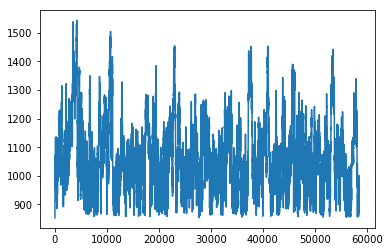

In [240]:
plt.plot(neurons)  # график количества нейронов в эпоху

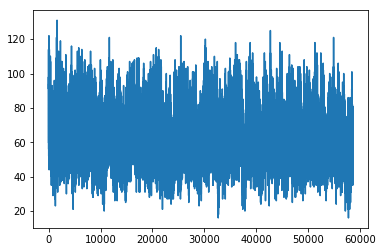

In [241]:
plt.plot(errors)  # график количества ошибок в эпоху

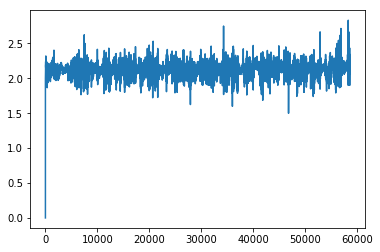

In [242]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

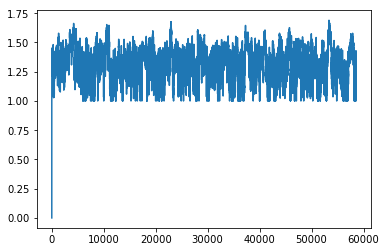

In [243]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

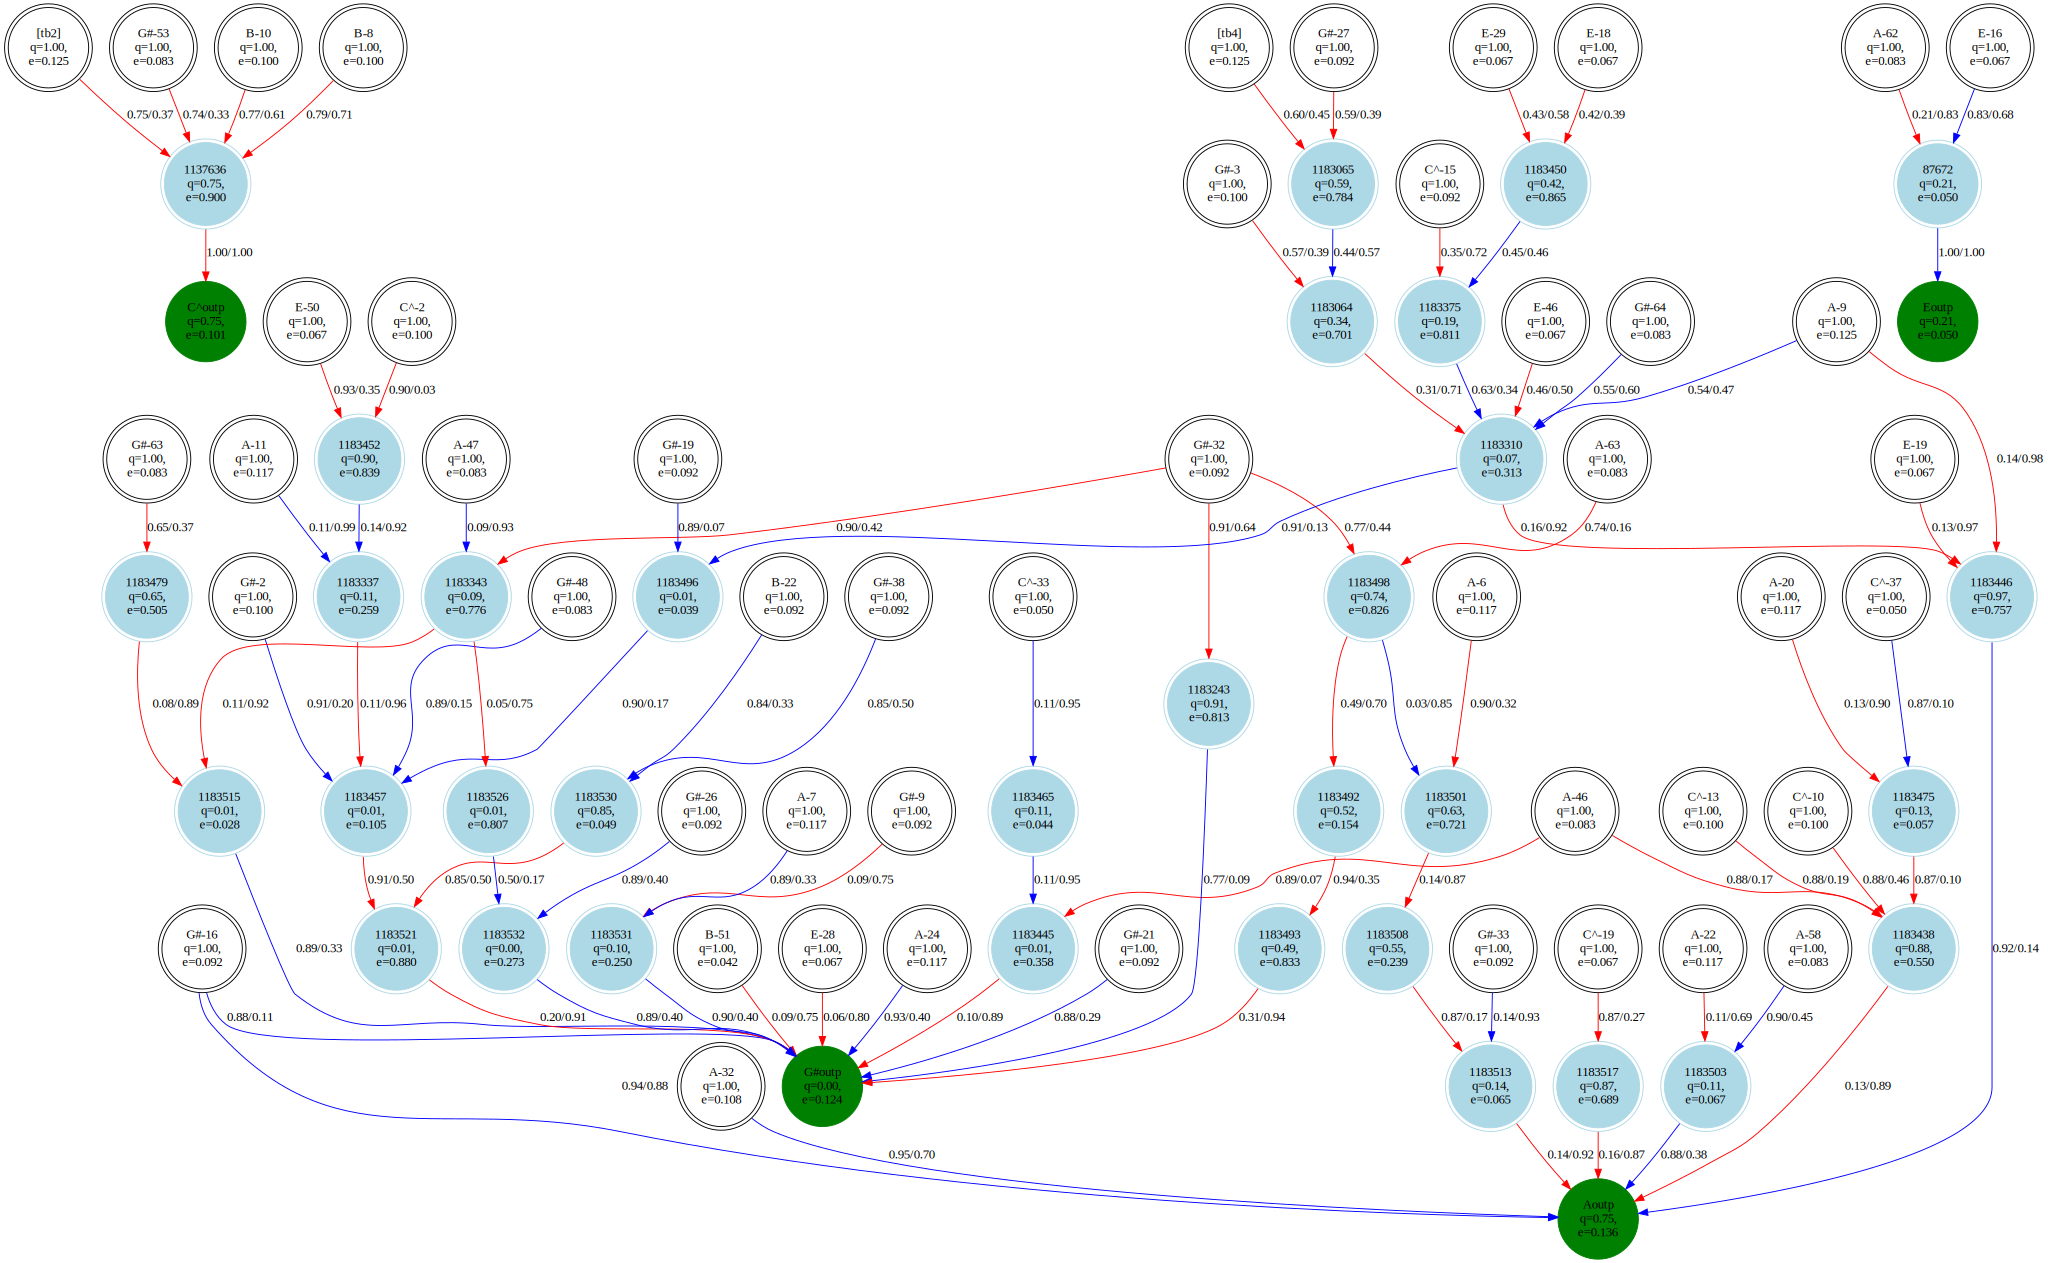

In [244]:
player.play_note.draw()

In [137]:
#player.play_note.draw().render('Бинарный слон') 

'Бинарный слон.png'

In [357]:
len(player.play_note.neurons)

947

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [138]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [139]:
simple_song = Song([12, -1, 11, -1, 9, -1, 8, -1])
result = player.improvise(simple_song)
result.play()

In [140]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [141]:
result.play()

## МНОГО ПЕСЕН

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [368]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [369]:
Songs = []
for i in range(1, 10):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

In [370]:
player = Player()

In [371]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])
neurons = []

In [372]:
while prev_errors.sum() > 10:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        neurons.append(len(player.play_note.neurons))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

99 111 91 75 73 79 101 121 59 107 74 71 146 99 174 98 70 76 69 101 97 80 111 
sum =  2182
128 116 57 115 82 76 90 89 73 58 71 53 67 66 85 168 82 63 53 70 77 56 67 
sum =  1862
78 66 42 55 52 64 69 79 36 58 58 47 54 44 73 57 56 60 45 62 60 37 64 
sum =  1316
71 56 37 39 54 53 62 73 35 61 61 54 82 50 78 59 71 72 50 89 68 46 87 
sum =  1408
62 73 49 58 60 68 65 100 55 79 67 41 69 52 69 62 67 70 52 77 67 55 82 
sum =  1499
78 58 40 53 50 54 67 74 39 67 94 66 63 58 72 84 74 67 72 99 84 52 80 
sum =  1545
87 60 48 48 65 75 88 88 55 67 92 78 71 72 87 95 89 77 47 103 74 57 73 
sum =  1696
95 58 51 44 64 69 82 67 44 62 81 67 55 56 75 73 58 52 52 61 62 66 75 
sum =  1469
75 68 35 54 56 55 70 77 40 55 73 102 70 50 72 62 73 70 45 64 53 43 73 
sum =  1435
75 59 50 50 55 54 59 69 40 48 58 64 59 51 67 59 59 57 58 75 98 59 73 
sum =  1396
92 63 71 66 61 69 73 69 63 52 63 68 49 53 59 67 57 51 49 68 63 50 66 
sum =  1442
69 69 36 44 56 48 63 71 43 46 58 50 46 42 63 48 53 64 49 61 63 40 68 
sum =  1250
7

KeyboardInterrupt: 

In [373]:
len(player.play_note.neurons)

1134

In [196]:
simple_song = Song('../basic midi/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [143]:
result.save_file("181. Binary Elephant NN learned kuznechik (94 hidden neurons)")

In [144]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [145]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()